In [1]:
import re
import pandas as pd
import numpy as np
# import more_itertools as mit
# from datetime import datetime
import missingno as msngo
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import seaborn as sns
import requests
import PIL
import io
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df_ori = pd.read_excel('XXEJE_Informe_Registro_de_Acti_081121.xls', header=0)
df_obj = df_ori.select_dtypes(['object'])
df_ori[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

In [3]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9464 entries, 0 to 9463
Data columns (total 61 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Libro                     9464 non-null   object 
 1   Rubro Subrubro Especie    9464 non-null   object 
 2   Rubro                     9464 non-null   int64  
 3   Subrubro                  9464 non-null   int64  
 4   Especie                   9464 non-null   int64  
 5   Número Activo             9464 non-null   int64  
 6   Descripción               9464 non-null   object 
 7   Número Etiqueta           9058 non-null   object 
 8   Fabricante                6395 non-null   object 
 9   Número Serie              9156 non-null   object 
 10  Modelo                    9298 non-null   object 
 11  Tipo Activo               9464 non-null   object 
 12  En Uso                    9464 non-null   object 
 13  Propiedad                 9464 non-null   object 
 14  Comprado

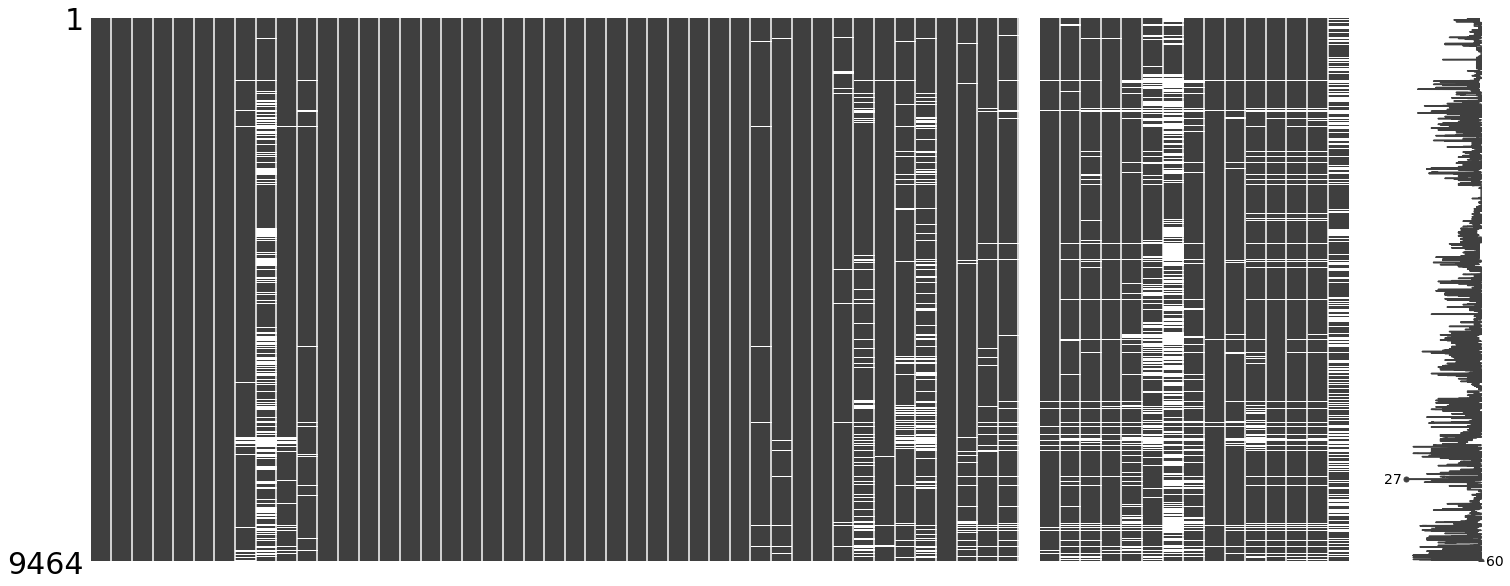

In [4]:
# df.head()
mat = msngo.matrix(df_ori)
mat.axes.tick_params(axis='y', labelsize=30)

In [5]:
df = df_ori[['Número Activo','Número Etiqueta', 'Descripción', 'Atributo 8', 'Modelo', 'UAC', 'UR', 'Atributo 2', 'Atributo 4', 'Atributo 5', 'Atributo 6', 'Atributo 9', 'Atributo 11', 'Atributo 19', 'Atributo 20', 'Atributo 24']]
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9464 entries, 0 to 9463
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Número Activo    9464 non-null   int64  
 1   Número Etiqueta  9058 non-null   object 
 2   Descripción      9464 non-null   object 
 3   Atributo 8       9397 non-null   object 
 4   Modelo           9298 non-null   object 
 5   UAC              9464 non-null   object 
 6   UR               9464 non-null   object 
 7   Atributo 2       9287 non-null   object 
 8   Atributo 4       9454 non-null   object 
 9   Atributo 5       9453 non-null   object 
 10  Atributo 6       9225 non-null   float64
 11  Atributo 9       8625 non-null   object 
 12  Atributo 11      9408 non-null   object 
 13  Atributo 19      8978 non-null   object 
 14  Atributo 20      8274 non-null   object 
 15  Atributo 24      9332 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory usage: 1.2+ MB


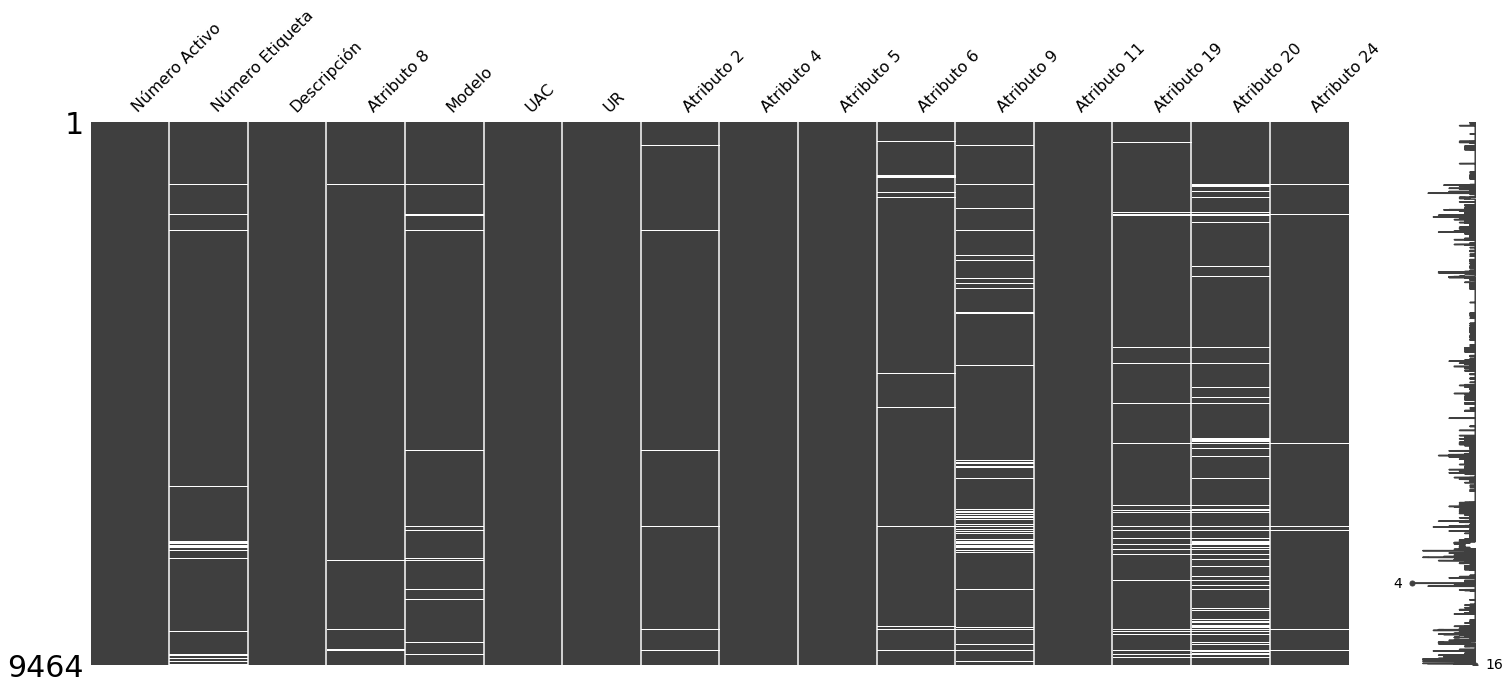

In [7]:
mat = msngo.matrix(df)
mat.axes.tick_params(axis='y', labelsize=30)

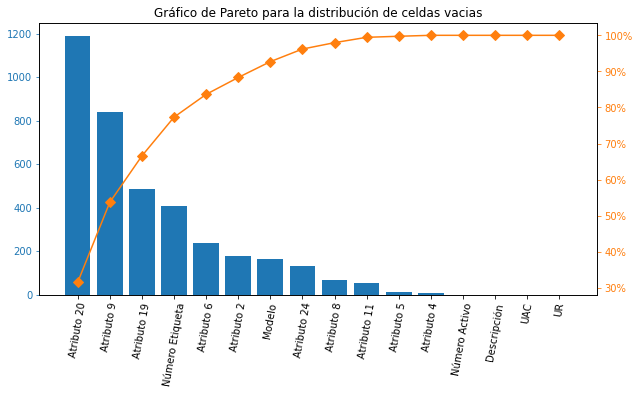

In [8]:
data_cvo = df.isna().sum().sort_values(ascending=False)
df_temp = pd.DataFrame({'columna': data_cvo.values})
df_temp.index = data_cvo.index
df_temp = df_temp.sort_values(by='columna',ascending=False)
df_temp["cumper"] = df_temp["columna"].cumsum()/df_temp["columna"].sum()*100


fig, ax = plt.subplots(figsize=(10,5))
ax.bar(df_temp.index, df_temp["columna"], color="C0")
ax2 = ax.twinx()
ax2.plot(df_temp.index, df_temp["cumper"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax.tick_params(axis="x", rotation=80)
ax2.tick_params(axis="y", colors="C1")
plt.title('Gráfico de Pareto para la distribución de celdas vacias')
plt.show()

In [9]:
# df['test'] = []
df['test'] = np.where(df['Número Etiqueta'].str.contains('\*'),1 , 0)
df['test'] = np.where(df['Número Etiqueta'].str.contains(' '),1 , df['test'])
df['test'] = np.where(df['Número Etiqueta'].str.contains('.'),1 , df['test'])
df['test'] = np.where(df['Número Etiqueta'].str.contains('REP.'),1 , df['test'])
# df['test'] = np.where(df['Número Etiqueta'].str.contains('XW6996'),1 , df['test'])
df['test'] = np.where(df['Número Etiqueta'].str.contains('SINMATRICULA'),1 , df['test'])
df['test'] = np.where(df['Número Etiqueta'].str.contains('S/M'),1 , df['test'])

print('Número de errores a correguir '+str(df['test'].value_counts()[1]))

df.drop(columns='test', inplace=True)

Número de errores a correguir 9464


In [10]:
chars_to_remove = ['*', ' ']
regular_expression = '[' + re.escape (''. join (chars_to_remove)) + ']'

df['Número Etiqueta'] = df['Número Etiqueta'].str.replace(regular_expression,'', regex=True)
df['Número Etiqueta'] = df['Número Etiqueta'].str.replace('.','-', regex=True)
df['Número Etiqueta'] = df['Número Etiqueta'].str.replace('REP-','', regex=True)
# df['Número Etiqueta'] = df['Número Etiqueta'].str.replace('XW6996','XW-6996', regex=True)
df['Número Etiqueta'] = df['Número Etiqueta'].str.replace('SINMATRICULA','', regex=True)
df['Número Etiqueta'] = df['Número Etiqueta'].str.replace('S/M','', regex=True)

In [11]:
b=0
for i, n in enumerate(df['Número Etiqueta']):
    try:
        a = n.split('-')
        if len(a) > 2:
            if (re.match(r'[a-zA-Z0-9]{1,4}-[a-zA-Z0-9]{1,4}-[a-zA-Z0-9]{0}$', n)):
                df.loc[i, 'Número Etiqueta'] = n[:-1]
                b=b+1
            if (re.match(r'[a-zA-Z0-9]{1,4}-[a-zA-Z0-9]{1,4}-[a-zA-Z0-9]{1}$', n)):
                df.loc[i, 'Número Etiqueta'] = n[:-2]    
                b=b+1
            if (re.match(r'[a-zA-Z0-9]{1,4}-[a-zA-Z0-9]{1,4}-[a-zA-Z0-9]{2}$', n)):
                df.loc[i, 'Número Etiqueta'] = n[:-3]
                b=b+1
            if (re.match(r'[a-zA-Z0-9]{1,4}-[a-zA-Z0-9]{1,4}-[a-zA-Z0-9]{3}$', n)):
                df.loc[i, 'Número Etiqueta'] = n[:-4]
                b=b+1
            if (re.match(r'[a-zA-Z0-9]{1,4}-[a-zA-Z0-9]{1,4}-[a-zA-Z0-9]{1,4}-[a-zA-Z0-9]{1,4}$', n)):
                df.loc[i, 'Número Etiqueta'] = n[:-3]
                b=b+1
    except:
        b=b+0

print('Errores relacionados a Patentes mal ingresadas '+str(b))

df.drop_duplicates(subset='Número Etiqueta', ignore_index=True, inplace=True)
# df.reset_index(drop=True, inplace=True)
# df

Errores relacionados a Patentes mal ingresadas 55


In [12]:
df['Número Etiqueta'].fillna('SIN', inplace=True)

In [13]:
palabras = []
cambios = []
for i, n in enumerate(df['Número Etiqueta']):
    match_w_n_w = re.findall("(([A-Z]+)([0-9]+)([A-Z]+))", n)
    match_n_w = re.findall("(([0-9]+)([A-Z]+))", n)
    match_w_n = re.findall("(([A-Z]+)([0-9]+))", n)
    if match_w_n_w:
        # palabras.append(match_w_n_w[0][0])
        palabras.append(n)
        b = []
        for (j, m) in list(enumerate(match_w_n_w[0]))[1:]:
            b.append(m)
        cambios.append('-'.join(b))
    elif match_n_w:
        # palabras.append(match_n_w[0][0])
        palabras.append(n)
        b = []
        for (j, m) in list(enumerate(match_n_w[0]))[1:]:
            b.append(m)
        cambios.append('-'.join(b))
    elif match_w_n:
        # palabras.append(match_w_n[0][0])
        palabras.append(n)
        b = []
        for (j, m) in list(enumerate(match_w_n[0]))[1:]:
            b.append(m)
        cambios.append('-'.join(b))
palabra_cambio = dict(zip(palabras, cambios))

In [14]:
for i, n in enumerate(palabra_cambio):
    if len(n)<len(palabra_cambio[n])+1:
        df['Número Etiqueta'] = df['Número Etiqueta'].str.replace(n, palabra_cambio[n], regex=False)

In [15]:
df['Atributo 2'] = df['Atributo 2'].str.replace('-', '', regex=False)
df['Atributo 2'].fillna(0, inplace=True)

In [16]:
b=0
for i, n in enumerate(df['Atributo 2']):
    try:
        a = n.split('.')
        if len(a) > 1:
            if len(a[-1]) < 1:
                df.loc[i, 'Atributo 2'] = n[:-1]
                b=b+1
    except:
        # print(n)
        b=b+0
        
b=0
for i, n in enumerate(df['Atributo 2']):
    try:
        a = n.split(',')
        if len(a) > 1:
            if (re.match(r'[0-9]+,[0-9]+,[0-9]+', n)):
                df.loc[i, 'Atributo 2'] = a[0]+'.'+a[1]+','+a[2]
                b=b+1
    except:
        # print(n)
        b=b+0
        
for i, n in enumerate(df['Atributo 2']):
    try:
        a = n.split(',')
        if len(a) > 1:
            if (re.match(r'[0-9]+,[0-9]+', n)):
                df.loc[i, 'Atributo 2'] = a[0]+'.'+a[1]
                # print(n)
                b=b+1
    except:
        # print(n)
        b=b+0

df['Atributo 2'] = df['Atributo 2'].str.replace('.', '', regex=False)
df['Atributo 2'] = df['Atributo 2'].str.replace(',', '.', regex=False)
df['Atributo 2'] = df['Atributo 2'].str.replace('. ', '.', regex=False)
df['Atributo 2'] = df['Atributo 2'].str.replace(' CL', '', regex=False)
df['Atributo 2'] = df['Atributo 2'].str.replace('NO APLICA', '0', regex=False)
df['Atributo 2'] = df['Atributo 2'].str.replace('/', '', regex=False)
df['Atributo 2'] = df['Atributo 2'].astype(float)

In [17]:
pd.set_option('display.max_rows', 5)
df[~df['Número Etiqueta'].str.contains('-')]

,Número Activo,Número Etiqueta,Descripción,Atributo 8,Modelo,UAC,UR,Atributo 2,Atributo 4,Atributo 5,Atributo 6,Atributo 9,Atributo 11,Atributo 19,Atributo 20,Atributo 24
12,163316,SIN,TANQUE,KRAUSS MAFFEI,LEOPARD 1V,VI_DE,RLD_N6,30100000.0,NO DISPONIBLE,BAJA,1972.0,0215105819-4,INNOMINADO,00.00.08.DIESEL,985,COMBATE
352,548614,8431,CARRO BLINDADO,MOWAG,PIRAÑA 6X6,DIVLOG,RLE_N2,345300.0,NO DISPONIBLE,BAJA POR AJUSTE,1982.0,0202150823-0,INNOMINADO,NaN,210,COMBATE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8998,640480,640480,BULLDOZER,JOHN DEERE,850J,I_DE,REG_REF_N1,240052.0,DISPONIBLE,ACTIVO,2017.0,SIN CIMAGE,INNOMINADO,..02.DIESEL,371 LTS,CAMPAÑA
9002,640484,640484,BULLDOZER,JOHN DEERE,850-J,VI_DE,REG_REF_N4,240052.0,NO DISPONIBLE,ACTIVO,2017.0,SIN CIMAGE,INNOMINADO,4.0.02.DIESEL,371 LTS,CAMPAÑA


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9004 entries, 0 to 9003
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Número Activo    9004 non-null   int64  
 1   Número Etiqueta  9004 non-null   object 
 2   Descripción      9004 non-null   object 
 3   Atributo 8       8963 non-null   object 
 4   Modelo           8914 non-null   object 
 5   UAC              9004 non-null   object 
 6   UR               9004 non-null   object 
 7   Atributo 2       8927 non-null   float64
 8   Atributo 4       9004 non-null   object 
 9   Atributo 5       9004 non-null   object 
 10  Atributo 6       8803 non-null   float64
 11  Atributo 9       8390 non-null   object 
 12  Atributo 11      8978 non-null   object 
 13  Atributo 19      8627 non-null   object 
 14  Atributo 20      8028 non-null   object 
 15  Atributo 24      8922 non-null   object 
dtypes: float64(2), int64(1), object(13)
memory usage: 1.1+ MB


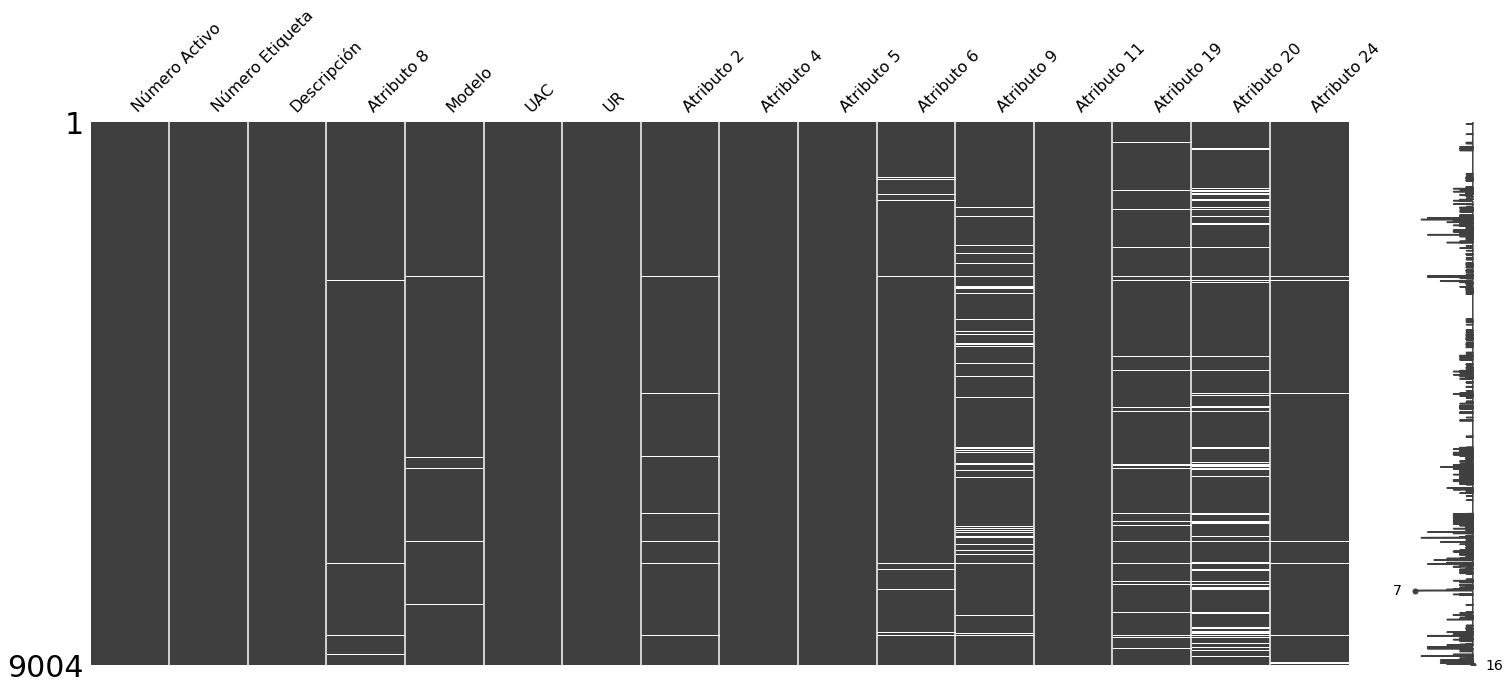

In [19]:
mat = msngo.matrix(df)
mat.axes.tick_params(axis='y', labelsize=30)

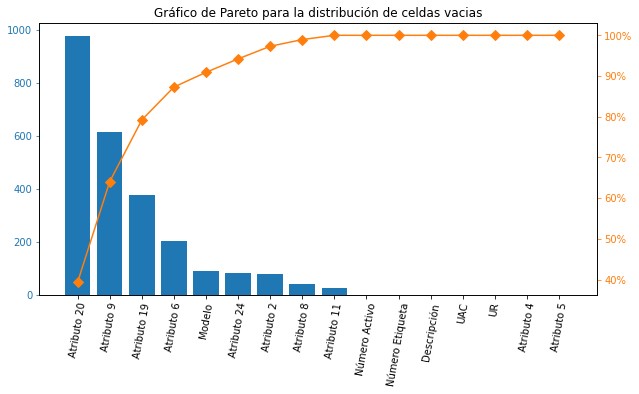

In [20]:
data_cvo = df.isna().sum().sort_values(ascending=False)
df_temp = pd.DataFrame({'columna': data_cvo.values})
df_temp.index = data_cvo.index
df_temp = df_temp.sort_values(by='columna',ascending=False)
df_temp["cumper"] = df_temp["columna"].cumsum()/df_temp["columna"].sum()*100


fig, ax = plt.subplots(figsize=(10,5))
ax.bar(df_temp.index, df_temp["columna"], color="C0")
ax2 = ax.twinx()
ax2.plot(df_temp.index, df_temp["cumper"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax.tick_params(axis="x", rotation=80)
ax2.tick_params(axis="y", colors="C1")
plt.title('Gráfico de Pareto para la distribución de celdas vacias')
plt.show()

In [21]:
df['Descripción'] = df['Descripción'].str.replace('ALJIBE PARA AGUA','REMOLQUE ALJIBE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('MINI CARGADOR','MINICARGADOR', regex=False)
df['Descripción'] = df['Descripción'].str.replace('MONTACARGA CON HORQUILLA','MONTACARGA', regex=False)
df['Descripción'] = df['Descripción'].str.replace('MOTO PARA NIEVE','MOTO DE NIEVE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('STATION WAGON','SUV', regex=False)
df['Descripción'] = df['Descripción'].str.replace('SEMIREMOLQUE CAMA BAJA','SEMIREMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('SEMIREMOLQUE EQUIPO LOGISTICO','SEMIREMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('SEMIREMOLQUE DE CARGA','SEMIREMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('REMOLQUE DE CARGA','REMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('REMOLQUE ESTANQUE','REMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('REMOLQUE PARA USO EN NIEVE','REMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('REMOLQUE EQUIPO LOGISTICO','REMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('REMOLQUE ALJIBE','REMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('REMOLQUE LIVIANO','REMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('REMOLQUE TRIPLE (MOTOCICLETA)','REMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('REMOLQUE TRIPLE','REMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('REMOLQUE DE ARRASTRE ANIMAL (USO AGRICOLA)','REMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('REMOLQUE MB 2300W','REMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('REMOLQUE PESADO','REMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('REMOLQUE CARGA (CUADRIMOTO)','REMOLQUE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('TRINEO DE ARRASTRE PARA MOTO DE NIEVE','TRINEO DE ARRASTRE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('TRINEO DE ARRASTRE ORION PARA MOTO DE NIEVE','TRINEO DE ARRASTRE', regex=False)
df['Descripción'] = df['Descripción'].str.replace('TRACTOR AGRICOLA','TRACTOR', regex=False)
df['Descripción'] = df['Descripción'].str.replace('CAMIONETA DE TRASNPORTE PERSONAL','CAMIONETA', regex=False)
df['Descripción'] = df['Descripción'].str.replace('CAMIONETA TRASNPORTE PERSONAL','CAMIONETA', regex=False)
df['Descripción'] = df['Descripción'].str.replace('CAMIONETA TRASNPORTE SHELTER','CAMIONETA', regex=False)
df['Descripción'] = df['Descripción'].str.replace('CAMIÓN','CAMION', regex=False)
df['Descripción'] = df['Descripción'].str.replace('CAMION TRASNPORTE SHELTER','CAMION', regex=False)
df['Descripción'] = df['Descripción'].str.replace('CAMION TRANSPORTE SHELTER','CAMION', regex=False)
df['Descripción'] = df['Descripción'].str.replace('JEEP DE TRASNPORTE','JEEP', regex=False)
df['Descripción'] = df['Descripción'].str.replace('CAMIONETA PARA ESTACION REPETIDORA','CAMIONETA', regex=False)
df['Descripción'] = df['Descripción'].str.replace('REMOLQUE ALGIBE','REMOLQUE', regex=False)
# df['Descripción'] = df['Descripción'].str.replace(' CAMA BAJA ','CAMA BAJA', regex=False)
df['Descripción'] = df['Descripción'].str.replace('CAMION DE TRANSPORTE','CAMION', regex=False)

In [22]:
df['Atributo 8'] = df['Atributo 8'].str.replace('ALTO AMERICAN- LINCOLN','AMERICAN LINCOLN', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('AM GENERAL','AM GEN', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('AM GEN','AM GENERAL', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('ASIA MOTORS','ASIA', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('ASIA','ASIA MOTORS', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('BARRETT','BARRET', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('BARRET','BARRETT', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('BEIT ALFA TRAILER CO','BEIT ALFA', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('BEIT-ALFA TRAILER CO.','BEIT ALFA', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('BLUMHART','BLUMHARDT', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('BOBCAT INGERSOLL RAND','BOBCAT', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('BOBCAT MODELO S630 FULLJ','BOBCAT', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('BOMBARDIER BRP SKI DOO','BOMBARDIER', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('BOX/CB2.SANCHEZ/Balatas,Neumaticos,Correa distribucion y turbo con eje gastados','', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('BROCK HOUSE','BROCKHOUSE', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('CARDOEN','CARDOEN-MOWAG', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('CATARPILLAR','CATERPILLAR', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('CATERPILAR','CATERPILLAR', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('CATERPILLAR 130-G','CATERPILLAR', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('CATERPILLAR D6D','CATERPILLAR', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('COMAND CAR','COMMANDCAR', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('COMANDCAR','COMMANDCAR', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('COMMANCAR','COMMANDCAR', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('COMMAND CAR','COMMANDCAR', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('CUSTROM','CUSTOM', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('DAHIATSU','DAIHATSU', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('FDERAL MOTOR COMPANY','FEDERAL MOTOR COMPANY', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('FEDERAL MOTOR COMPANY','FEDERAL', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('FEDERAL','FEDERAL MOTOR COMPANY', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('FMC CORPORATION','FEDERAL MOTOR COMPANY', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('FORD RANGER','FORD', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('HYNDAI','HYUNDAI', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('HYUNDAY','HYUNDAI', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('HYUYNDAI','HYUNDAI', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('ELANTRA','HYUNDAI', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('INCA FREUHAUF','INCA', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('INCA FRUEHAUF','INCA', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('ISUSU','ISUZU', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('IZUSU','ISUZU', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('JOHNSON','TEST', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('JHON DEERE','JOHN', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('JOHN DEERE','JOHN', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('JHON DEER','JOHN', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('JOHN','JOHN DEERE', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('TEST','JOHNSON', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('KIA MOTORS','KIA', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('KIA SORENTO','KIA', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('KOMATSU PC 130-8','KOMATSU', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('M/BENZ','MERCEDES BENZ', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('MERC. BENZ','MERCEDES BENZ', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('MERCEDEZ BENZ','MERCEDES BENZ', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('MERCEDEZ-BENZ','MERCEDES BENZ', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('MERCEDES BENZ   ','MERCEDES BENZ', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('MERCEDES BENZ\t','MERCEDES BENZ', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('MAK','MACK', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('nissan','NISSAN', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('NETZER SERENI','NETZER', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('N.A','', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('N.A.','', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('SIM MARCA','', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('SIN INFORMACION','', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('SIN MARCA','', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('NO APLICA','', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('S/M','', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('POLARIS DEFENSE','POLARIS', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('POLARIS','DEFENSE', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('RANDOM','RANDON', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('TECNOVE SEGURITY','TECNOVE SECURITY', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('TOYOTA CAMRI','TOYOTA', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('TOYOTA LAND CRUISER II','TOYOTA', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('TOYOTA LAND CRUISER','TOYOTA', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('WILLYS BANTAM','WILLYS', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('SUZUKY','SUZUKI', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('ZUZUKI DR 350','SUZUKI', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('AUTOMOTIVE INDUSTRIES LTDA','AUTOMOTIVE INDUSTRIES LTD', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('AUTOMOVILE INDUST LTDA','AUTOMOTIVE INDUSTRIES LTD', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('BUICK SGM6531UAAA','BUICK', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('CHEVROLET DMAX','CHEVROLET', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('FORD AMBULANCIA','FORD', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('LIFTKING LK 630 R','LIFTKING', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('METALBERT LTDA.','METALBERT', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('METALVERT LTDA.','METALBERT', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('MITSIBISHI','MITSUBISHI', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('MITSUBISHI KATANA','MITSUBISHI', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('TECNOVE SECURITY','TECNOVE', regex=False)
df['Atributo 8'] = df['Atributo 8'].str.replace('.','', regex=False)

In [23]:
# pd.options.display.max_rows = None
temp = df['Atributo 8'].value_counts().reset_index().rename(columns={'index':'Atributo 8', 'Atributo 8':'Cantidad'}).sort_values(by='Atributo 8', ascending=True)
# print(len(temp))
# temp

In [24]:
pd.options.display.max_rows = 10
df[df['Atributo 8']==temp['Atributo 8'][0]]['Modelo'].value_counts().reset_index().rename(columns={'index':'Modelo', 'Modelo':'Cantidad'})#.sort_values(by='Modelo', ascending=True)

,Modelo,Cantidad
0,1017-A,582
1,UNIMOG 1300L,484
2,UNIMOG 4000,185
3,ATEGO 1023-A,103
4,SPRINTER,65
...,...,...
195,"BRAS CAIO LO-812/42,5",1
196,BRAS CAIO OF 1318/52,1
197,1725,1
198,ACTROS 2632 AK,1


In [25]:
temp['Atributo 8'][0]

'MERCEDES BENZ'

In [26]:
df_temp = df[df['Atributo 8']==temp['Atributo 8'][0]]['Modelo']
df_temp.fillna('SIN MODELO', inplace=True)
df_temp = df_temp.str.replace('M-', 'M ', regex=False)
df_temp = df_temp.str.replace('-', '', regex=False)

C:\Users\Lanzet\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [27]:
palabras = []
cambios = []
for i, n in enumerate(df_temp):
    match_w_n_w = re.findall("(([A-Z]+)([0-9]+)([A-Z]+))", n)
    match_n_w = re.findall("(([0-9]+)([A-Z]+))", n)
    match_w_n = re.findall("(([A-Z]+)([0-9]+))", n)
    if match_w_n_w:
        palabras.append(match_w_n_w[0][0])
        b = []
        for (j, m) in list(enumerate(match_w_n_w[0]))[1:]:
            b.append(m)
        cambios.append(' '.join(b))
    elif match_n_w:
        palabras.append(match_n_w[0][0])
        b = []
        for (j, m) in list(enumerate(match_n_w[0]))[1:]:
            b.append(m)
        cambios.append(' '.join(b))
    elif match_w_n:
        palabras.append(match_w_n[0][0])
        b = []
        for (j, m) in list(enumerate(match_w_n[0]))[1:]:
            b.append(m)
        cambios.append(' '.join(b))
palabra_cambio = dict(zip(palabras, cambios))

In [28]:
for i, n in enumerate(palabra_cambio):
    df_temp = df_temp.str.replace(n, palabra_cambio[n], regex=False)

In [29]:
df_temp = df_temp.str.replace('VERSATILE', 'VERSATIL', regex=False)
df_temp = df_temp.str.replace('VERSATIL', 'VERSATILE', regex=False)
df_temp = df_temp.str.replace('VICTORIA', 'VITORIA', regex=False)
df_temp = df_temp.str.replace('COMILVERSATILE', 'COMIL VERSATILE', regex=False)
df_temp = df_temp.str.replace('H 1', 'H1', regex=False)

In [30]:
stop_words = frozenset(['verde', 'modelo'])
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=5,                        # minimum read occurences of a word 
                             stop_words=stop_words,             # remove stop words
                             strip_accents='unicode',
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{2,}',  # num chars > 3
                             max_features=5000,               # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(df_temp)

In [31]:
words = vectorizer.get_feature_names()
words_freq = data_vectorized.toarray().sum(axis= 0)
tops = pd.DataFrame(list(zip(words, words_freq)), columns =['Words', 'Freq']).sort_values(by = 'Freq', ascending=False).reset_index(drop=True)
tops['Log_Freq'] = np.log(tops['Freq'])

In [32]:
pd.options.display.max_rows = None
tops

,Words,Freq,Log_Freq
0,unimog,882,6.782192
1,1017,655,6.484635
2,1300,598,6.393591
3,atego,261,5.564520
4,4000,238,5.472271
5,1023,140,4.941642
6,2632,115,4.744932
7,ak,111,4.709530
8,actros,108,4.682131
9,1721,98,4.584967


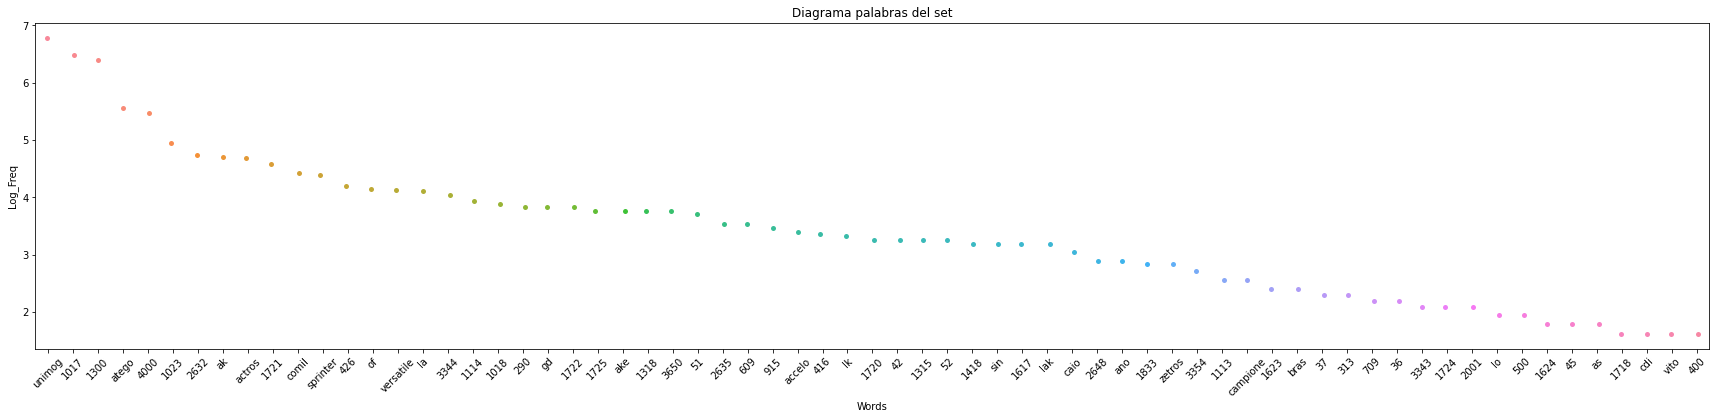

In [33]:
plt.figure(figsize=(30,6))
ax=sns.stripplot(data=tops, x='Words', y='Log_Freq')
plt.setp(ax.get_xticklabels(),rotation=45)
plt.title('Diagrama palabras del set')
plt.show()

In [34]:
df_temp[df_temp.str.contains('(?i)unimog')]

1997                      UNIMOG 4000
1998    UNIMOG 4000 ESTÁNDAR AÑO 2015
1999    UNIMOG 4000 ESTÁNDAR AÑO 2015
2000     UNIMOG 1300 L AÑO 1986 VERDE
2001     UNIMOG 1300 L AÑO 1984 VERDE
2003                    UNIMOG 1300 L
2006                    UNIMOG 1300 L
2017     UNIMOG 1300 L AÑO 1985 VERDE
2018     UNIMOG 1300 L AÑO 1985 VERDE
2019     UNIMOG 1300 L AÑO 1985 VERDE
2020                    UNIMOG 1300 L
2021                    UNIMOG 1300 L
2024                    UNIMOG 1300 L
2025                    UNIMOG 1300 L
2026                      UNIMOG 4000
2027                      UNIMOG 4000
2028                      UNIMOG 4000
2029                      UNIMOG 4000
2030                      UNIMOG 4000
2031                      UNIMOG 4000
2032                    UNIMOG 1300 L
2033                    UNIMOG 1300 L
2034                      UNIMOG 4000
2035                      UNIMOG 4000
2037                      UNIMOG 4000
2038                      UNIMOG 4000
2039        

In [35]:
df['Atributo 19']=np.where(df['Atributo 19'].str.contains('DIESEL'), 'DIESEL', df['Atributo 19'])
df['Atributo 19']=np.where(df['Atributo 19'].str.contains('BENCI'), 'BENCINERO', df['Atributo 19'])
df['Atributo 19']=np.where(df['Atributo 19'].str.contains('NO APLICA'), 'NO APLICA', df['Atributo 19'])
df['Atributo 19']=np.where((df['Atributo 19'].str.contains('NO APLICA')) | (df['Atributo 19'].str.contains('DIESEL')) | (df['Atributo 19'].str.contains('BENCI')), df['Atributo 19'], 'NO APLICA')

In [36]:
df['Atributo 20'] = df['Atributo 20'].str.extract('(\d+)', expand=False)
df['Atributo 20'] = pd.to_numeric(df['Atributo 20'])

In [37]:
df_test = df.copy()

In [38]:
df_test.to_csv('Clean_Bd_Vehic.csv', encoding='latin-1', index=False)

# df_test.to_excel('Clean_Bd_Vehic.xlsx', encoding='latin-1', index=False)